In [1]:
import os
import torch
import matplotlib.pyplot as plt
import xml.dom.minidom
from skimage.io import imread
from skimage import img_as_ubyte
from pyrr import Matrix44, Vector4, Vector3
import pyrr

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, 
    BlendParams,
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    HardPhongShader,
    SoftSilhouetteShader
)
from pytorch3d.renderer.cameras import look_at_view_transform

from torch_openpose.body import Body
from torch_openpose import util
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

from tqdm import tqdm
import torch.nn as nn
import imageio
import cv2
import copy
from PIL import ImageFont, ImageDraw, Image

import wandb

# add path for demo utils functions 
import glob
import sys
import os
sys.path.append(os.path.abspath(''))
import pytorch3d
from pytorch3d_utils import where, mitsuba_scene_to_torch_3d_no_ground, add_background, get_body_image_from_mesh


Bad key "text.kerning_factor" on line 4 in
/home/ax/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def join_meshes_with_texture(tshirt_meshes, length, tshirt_vertex_color_snapshot_path=None):
    textures = []
    vertices = []
    faces = []
    for index in range(length):
        tshirt_vetrices, tshirt_faces = tshirt_meshes.get_mesh_verts_faces(index)
        # flip 
        tshirt_vetrices[:, 2] *= -1
        
        # texture
        if tshirt_vertex_color_snapshot_path is None:
            texTshirt = torch.ones_like(tshirt_vetrices).cuda()
            texTshirt[:, 1:] *= 0.0  # red
        else:
            texTshirt_np = np.load(tshirt_vertex_color_snapshot_path)
            texTshirt = torch.from_numpy(texTshirt_np).cuda()
        tex = torch.cat([texTshirt]).cuda()
        textures.append(tex)
        
        verts = torch.cat([tshirt_vetrices]).cuda()  #(204, 3)
        vertices.append(verts)
        
        cur_faces = torch.cat([tshirt_faces]).cuda()  
        faces.append(cur_faces)
    
    textures = Textures(verts_rgb=torch.stack(textures))
    joined_meshes = Meshes(verts=vertices, faces=faces, textures=textures)
    return joined_meshes
        

In [3]:
ORIG_SHAPE = (512, 512, 3)
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)
tshirt_mesh_filenames = ['/home/ax/data/radekDataset/SPRING_MALE_RESAMPLED/mesh39_animated/clothes/tshirt_final_fine.obj']
tshirt_meshes = load_objs_as_meshes(tshirt_mesh_filenames, device=device)
body_estimation = Body('/home/ax/data/programs/pytorch-openpose/model/body_pose_model.pth', True)

# set defaults
body_estimation.imageToTest_padded_shape = ORIG_SHAPE
body_estimation.pad = [0, 0, 0, 0]

In [4]:
joined_meshes_noise = join_meshes_with_texture(
    tshirt_meshes, 
    1, 
    '../snapshots/vertex_color_bg_kl_tshirt_torch.npy')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'With background')

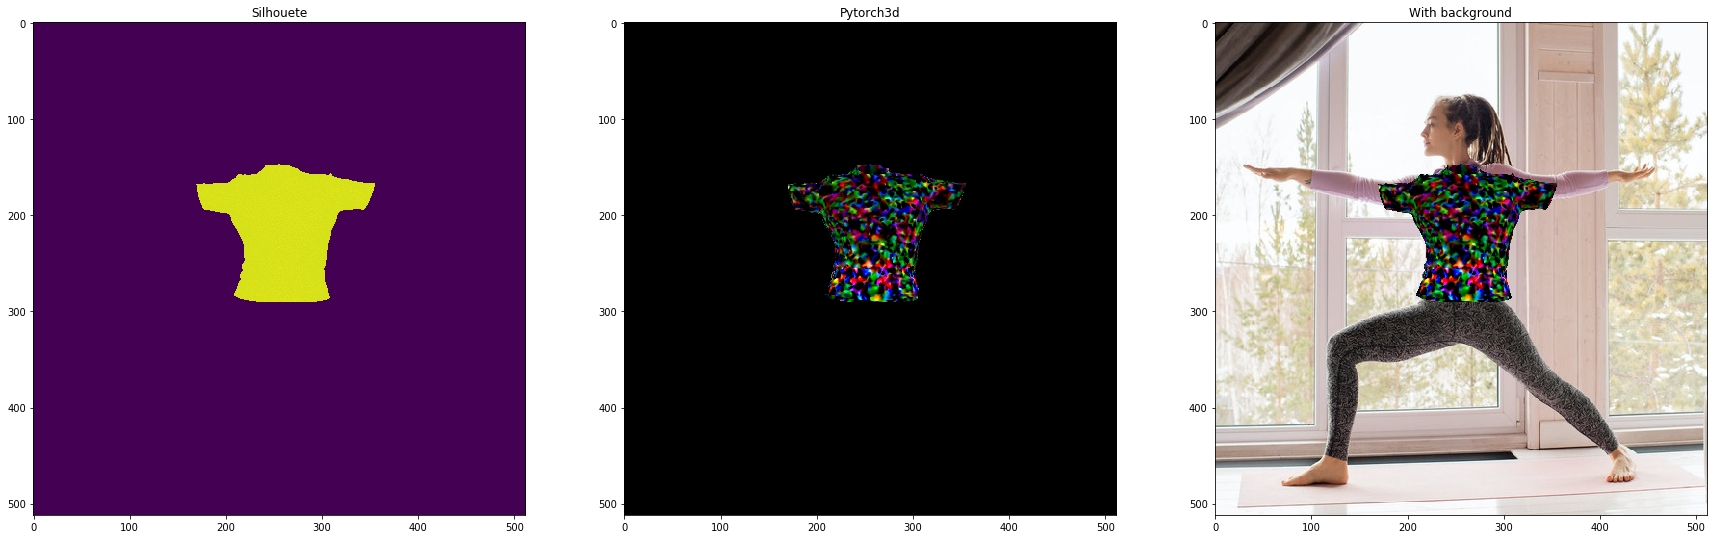

In [5]:
ORIG_SHAPE = (512, 512, 3)
BG_PATH = '../data/real_poose_backgrounds/yoga2.jpg'
R, T = look_at_view_transform(8000.0, 180, 0) 
T[0, 1] = -930.0
T[0, 0] = -30.0

cameras = OpenGLPerspectiveCameras(
        znear=0.1,
        zfar=10000,
        fov=15,
        degrees=True,
        device=device, 
        R=R, 
        T=T
    )

raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1,
    perspective_correct=True,
)
batch_size = 1
ambient_color = torch.tensor([[0.5, 0.5, 0.5]]).repeat(batch_size, 1)
diffuse_color = torch.tensor([[0.3, 0.3, 0.3]]).repeat(batch_size, 1)
specular_color = torch.tensor([[0.2, 0.2, 0.2]]).repeat(batch_size, 1)
lights = DirectionalLights(
            device=device, 
            direction=torch.tensor([[0.0, 0.0, 1.0]]),
            ambient_color=ambient_color,
            diffuse_color=diffuse_color,
            specular_color=specular_color
        )

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ), 
    shader=HardPhongShader(
        device=device, 
        cameras=cameras, 
        lights=lights
    )
)
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)

mesh = joined_meshes_noise[0]
image = renderer(mesh)   # (1, H, W, 4)
silhouette = silhouette_renderer(mesh)   # (1, H, W, 4)

background = cv2.imread(BG_PATH)
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
background = torch.from_numpy(background / 255).unsqueeze(0).float().cuda()
alpha = torch.ones((1, 512, 512, 1)).cuda()
background = torch.cat([background, alpha], 3)


alpha_mask = torch.cat([silhouette[..., 3], silhouette[..., 3], silhouette[..., 3], silhouette[..., 3]], 0)
alpha_mask = alpha_mask.unsqueeze(0).permute((0, 2, 3, 1))

final = where(alpha_mask > 0, image, background)

silhouette = silhouette.cpu().numpy()
final = final.cpu().numpy()


fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(silhouette.squeeze()[..., 3])

ax.set_title("Silhouete")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(image.squeeze().cpu().numpy())
ax.set_title("Pytorch3d")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(final.squeeze())
ax.set_title("With background")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


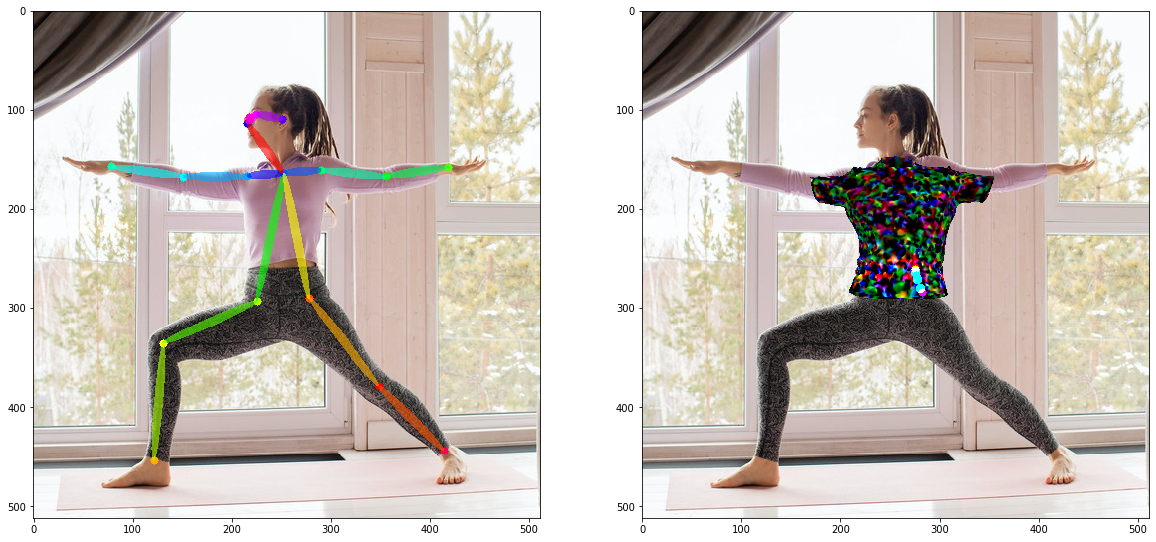

In [6]:
BG_PATH = '../data/real_poose_backgrounds/yoga2.jpg'
R, T = look_at_view_transform(8000.0, 180, 0) 
T[0, 1] = -930.0
T[0, 0] = -30.0

cameras = OpenGLPerspectiveCameras(
        znear=0.1,
        zfar=10000,
        fov=15,
        degrees=True,
        device=device, 
        R=R, 
        T=T
    )


renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ), 
    shader=HardPhongShader(
        device=device, 
        cameras=cameras, 
        lights=lights
    )
)
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)



real_input = cv2.imread(BG_PATH)
candidate, subset = body_estimation(real_input)
canvas_orig = copy.deepcopy(real_input)
canvas_orig = util.draw_bodypose(canvas_orig, candidate, subset)


mesh = joined_meshes_noise[0]
image = renderer(mesh)   # (1, H, W, 4)
silhouette = silhouette_renderer(mesh)   # (1, H, W, 4)

background = cv2.imread(BG_PATH)
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
background = torch.from_numpy(background / 255).unsqueeze(0).float().cuda()
alpha = torch.ones((1, 512, 512, 1)).cuda()
background = torch.cat([background, alpha], 3)


alpha_mask = torch.cat([silhouette[..., 3], silhouette[..., 3], silhouette[..., 3], silhouette[..., 3]], 0)
alpha_mask = alpha_mask.unsqueeze(0).permute((0, 2, 3, 1))

cur_image = where(alpha_mask > 0, image, background)

# Save outputs to create a GIF. 
rendering_torch_input = (cur_image[..., :3] - 0.5).permute((0, 3, 1, 2)).float()

heatmap_avg, paf_avg = body_estimation.compute_heatmap_paf_avg(rendering_torch_input, ORIG_SHAPE)
candidate, subset = body_estimation.get_pose(heatmap_avg, paf_avg, ORIG_SHAPE)
rendering_torch_np =  cur_image[0, ..., :3].detach().squeeze().cpu().numpy()
canvas_noise = copy.deepcopy(rendering_torch_np)
canvas_noise = util.draw_bodypose(canvas_noise, candidate, subset)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(canvas_orig[:, :, [2, 1, 0]])

ax = fig.add_subplot(1, 2, 2)
ax.imshow(canvas_noise)


fig.savefig('../results/pytorch3d/real1.png', dpi=100, bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


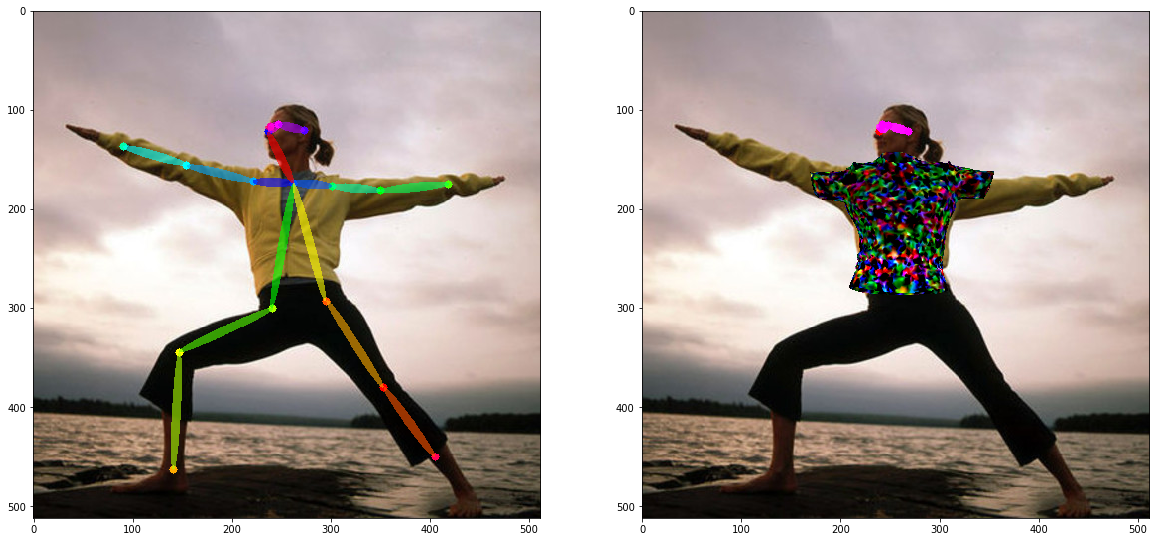

In [12]:
BG_PATH = '../data/real_poose_backgrounds/yoga.jpg'
R, T = look_at_view_transform(8000.0, 180, 0) 

T[0, 1] = -910
T[0, 0] = -30.0

cameras = OpenGLPerspectiveCameras(
        znear=0.1,
        zfar=10000,
        fov=15,
        degrees=True,
        device=device, 
        R=R, 
        T=T
    )


renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ), 
    shader=HardPhongShader(
        device=device, 
        cameras=cameras, 
        lights=lights
    )
)
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)



real_input = cv2.imread(BG_PATH)
candidate, subset = body_estimation(real_input)
canvas_orig = copy.deepcopy(real_input)
canvas_orig = util.draw_bodypose(canvas_orig, candidate, subset)


mesh = joined_meshes_noise[0]
image = renderer(mesh)   # (1, H, W, 4)
silhouette = silhouette_renderer(mesh)   # (1, H, W, 4)

background = cv2.imread(BG_PATH)
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
background = torch.from_numpy(background / 255).unsqueeze(0).float().cuda()
alpha = torch.ones((1, 512, 512, 1)).cuda()
background = torch.cat([background, alpha], 3)


alpha_mask = torch.cat([silhouette[..., 3], silhouette[..., 3], silhouette[..., 3], silhouette[..., 3]], 0)
alpha_mask = alpha_mask.unsqueeze(0).permute((0, 2, 3, 1))

cur_image = where(alpha_mask > 0, image, background)

# Save outputs to create a GIF. 
rendering_torch_input = (cur_image[..., :3] - 0.5).permute((0, 3, 1, 2)).float()

heatmap_avg, paf_avg = body_estimation.compute_heatmap_paf_avg(rendering_torch_input, ORIG_SHAPE)
candidate, subset = body_estimation.get_pose(heatmap_avg, paf_avg, ORIG_SHAPE)
rendering_torch_np =  cur_image[0, ..., :3].detach().squeeze().cpu().numpy()
canvas_noise = copy.deepcopy(rendering_torch_np)
canvas_noise = util.draw_bodypose(canvas_noise, candidate, subset)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(canvas_orig[:, :, [2, 1, 0]])

ax = fig.add_subplot(1, 2, 2)
ax.imshow(canvas_noise)

fig.savefig('../results/pytorch3d/real2.png', dpi=100, bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


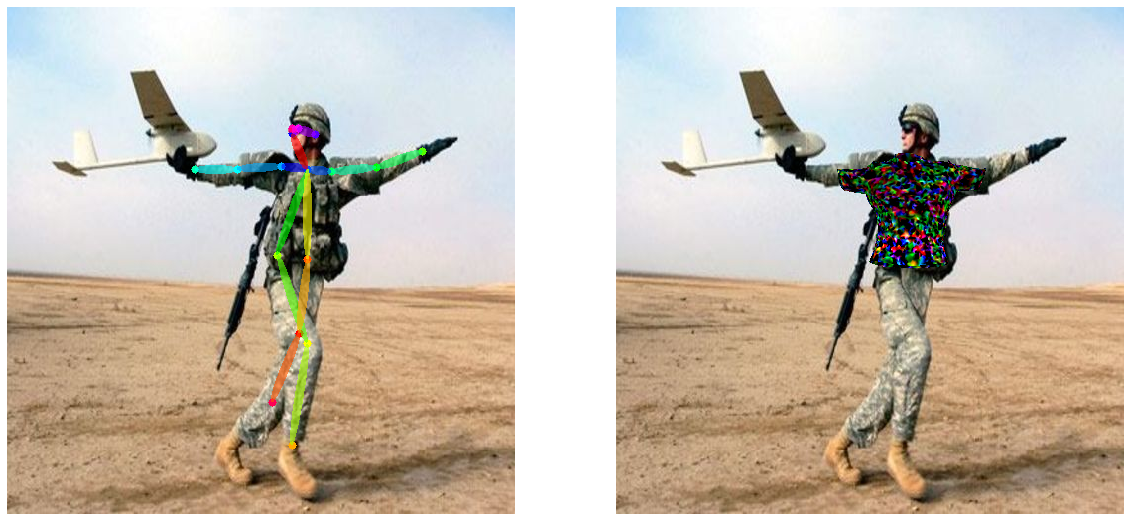

In [31]:
BG_PATH = '../data/real_poose_backgrounds/soldier4.jpg'
R, T = look_at_view_transform(10000.0, 180, 0) 

T[0, 1] = -820
T[0, 0] = -225.0

cameras = OpenGLPerspectiveCameras(
        znear=0.1,
        zfar=10000,
        fov=15,
        degrees=True,
        device=device, 
        R=R, 
        T=T
    )


renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ), 
    shader=HardPhongShader(
        device=device, 
        cameras=cameras, 
        lights=lights
    )
)
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)



real_input = cv2.imread(BG_PATH)
candidate, subset = body_estimation(real_input)
canvas_orig = copy.deepcopy(real_input)
canvas_orig = util.draw_bodypose(canvas_orig, candidate, subset)


mesh = joined_meshes_noise[0]
image = renderer(mesh)   # (1, H, W, 4)
silhouette = silhouette_renderer(mesh)   # (1, H, W, 4)

background = cv2.imread(BG_PATH)
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
background = torch.from_numpy(background / 255).unsqueeze(0).float().cuda()
alpha = torch.ones((1, 512, 512, 1)).cuda()
background = torch.cat([background, alpha], 3)


alpha_mask = torch.cat([silhouette[..., 3], silhouette[..., 3], silhouette[..., 3], silhouette[..., 3]], 0)
alpha_mask = alpha_mask.unsqueeze(0).permute((0, 2, 3, 1))

cur_image = where(alpha_mask > 0, image, background)

# Save outputs to create a GIF. 
rendering_torch_input = (cur_image[..., :3] - 0.5).permute((0, 3, 1, 2)).float()

heatmap_avg, paf_avg = body_estimation.compute_heatmap_paf_avg(rendering_torch_input, ORIG_SHAPE)
candidate, subset = body_estimation.get_pose(heatmap_avg, paf_avg, ORIG_SHAPE)
rendering_torch_np =  cur_image[0, ..., :3].detach().squeeze().cpu().numpy()
canvas_noise = copy.deepcopy(rendering_torch_np)
canvas_noise = util.draw_bodypose(canvas_noise, candidate, subset)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(canvas_orig[:, :, [2, 1, 0]])
ax.axis('off')

ax = fig.add_subplot(1, 2, 2)
ax.imshow(canvas_noise)
ax.axis('off')

fig.savefig('../results/pytorch3d/soldier.png', dpi=100, bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


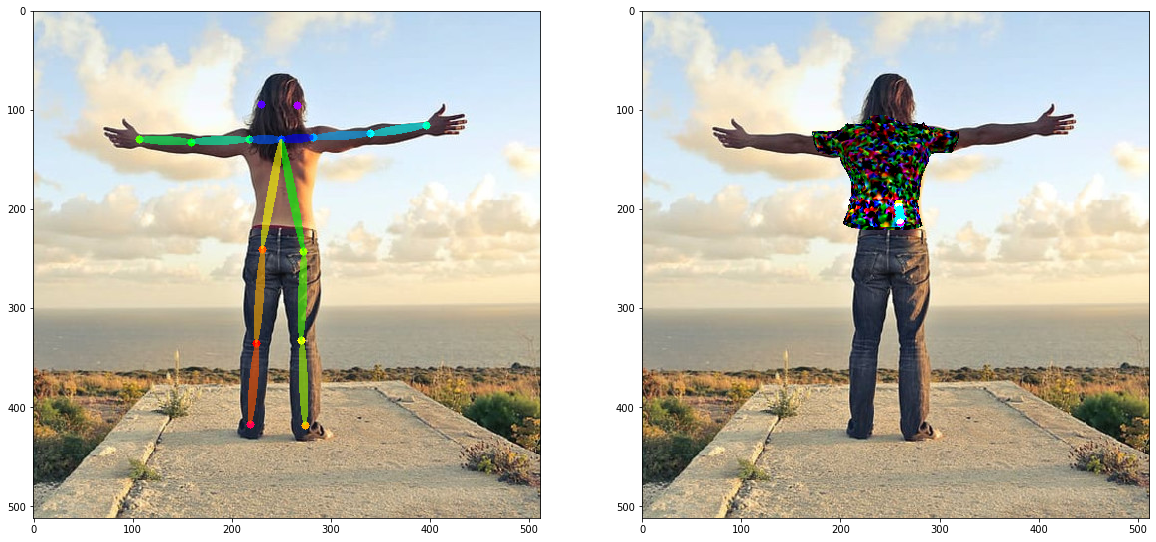

In [13]:
BG_PATH = '../data/real_poose_backgrounds/man.jpg'
R, T = look_at_view_transform(10000.0, 180, 0) 

T[0, 1] = -600
T[0, 0] = 50.0

cameras = OpenGLPerspectiveCameras(
        znear=0.1,
        zfar=10000,
        fov=15,
        degrees=True,
        device=device, 
        R=R, 
        T=T
    )


renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ), 
    shader=HardPhongShader(
        device=device, 
        cameras=cameras, 
        lights=lights
    )
)
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)



real_input = cv2.imread(BG_PATH)
candidate, subset = body_estimation(real_input)
canvas_orig = copy.deepcopy(real_input)
canvas_orig = util.draw_bodypose(canvas_orig, candidate, subset)


mesh = joined_meshes_noise[0]
image = renderer(mesh)   # (1, H, W, 4)
silhouette = silhouette_renderer(mesh)   # (1, H, W, 4)

background = cv2.imread(BG_PATH)
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
background = torch.from_numpy(background / 255).unsqueeze(0).float().cuda()
alpha = torch.ones((1, 512, 512, 1)).cuda()
background = torch.cat([background, alpha], 3)


alpha_mask = torch.cat([silhouette[..., 3], silhouette[..., 3], silhouette[..., 3], silhouette[..., 3]], 0)
alpha_mask = alpha_mask.unsqueeze(0).permute((0, 2, 3, 1))

cur_image = where(alpha_mask > 0, image, background)

# Save outputs to create a GIF. 
rendering_torch_input = (cur_image[..., :3] - 0.5).permute((0, 3, 1, 2)).float()

heatmap_avg, paf_avg = body_estimation.compute_heatmap_paf_avg(rendering_torch_input, ORIG_SHAPE)
candidate, subset = body_estimation.get_pose(heatmap_avg, paf_avg, ORIG_SHAPE)
rendering_torch_np =  cur_image[0, ..., :3].detach().squeeze().cpu().numpy()
canvas_noise = copy.deepcopy(rendering_torch_np)
canvas_noise = util.draw_bodypose(canvas_noise, candidate, subset)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(canvas_orig[:, :, [2, 1, 0]])

ax = fig.add_subplot(1, 2, 2)
ax.imshow(canvas_noise)
fig.savefig('../results/pytorch3d/real3.png', dpi=100, bbox_inches='tight')